# **Cluster**

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster

## Inputs

* outputs/datasets/collection/mushrooms.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety'

---

# Load Data

In [5]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/mushrooms.csv")

print(df.shape)
df.head()

(8124, 23)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,0,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,1,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


---

# Cluster Mushroom Pipeline with all data

## ML Cluster Pipeline

As previously identified in the Data Cleaning notebook, no data cleaning is needed. Target Encoding followed by Smart Correlated Selection will be used as before. Principal Component Analysis will then been performed to extract correlated components that explain the variance in the data. K-means clustering will be applied to the principal components to identify a set number of clusters.

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from category_encoders import TargetEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# ML algorithm
from sklearn.cluster import KMeans

cols = df.columns[df.dtypes=='object'].to_list()

cat_list=[]

for col in cols:
    cat_list.append(list(df[col].unique()))

def PipelineCluster():
    """ Creates a pipeline for a k-means clustering model """
    pipeline_base = Pipeline([
        ("TargetEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=50, random_state=0)),
        ("model", KMeans(n_clusters=50, random_state=0)),
    ])
    return pipeline_base

## Principal Component Analysis (PCA)

In [8]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df, df['edible'])

print(df_pca.shape,'\n', type(df_pca))

(8124, 17) 
 <class 'numpy.ndarray'>


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Apply PCA separately to the scaled data to determine how many principal components account for the variance in the data.

* The 17 components explain 100.0% of the data 



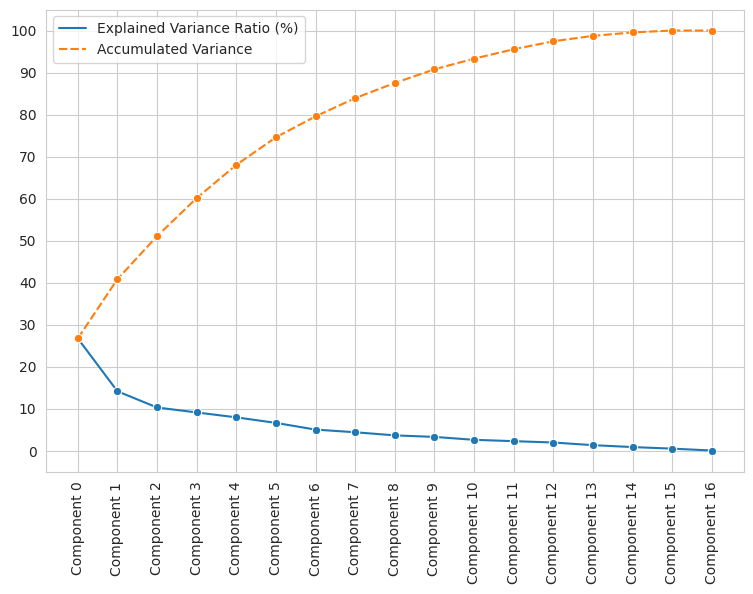

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 17

def pca_components_analysis(df_pca, n_components):
    """ performs analysis on the number of components needed to explain the variance in the dataset and visually plots this """
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum()

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

In order to reduce the complexity of the model, only the most relevant components which explain the majority of the variance in the dataset will be used. For this, we will look at taking the 6 most important components.

In [ ]:
n_components = 6
pca_components_analysis(df_pca=df_pca, n_components=n_components)

Will set `n_components` argument of PCA to 6. 

In [ ]:
def PipelineCluster():
    """ Creates a pipeline for a k-means clustering model """
    pipeline_base = Pipeline([
        ("TargetEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=6, random_state=0)),
        ("model", KMeans(n_clusters=50, random_state=0)),
    ])
    return pipeline_base


PipelineCluster()

## Elbow Method and Silhouette Score

Initialize the new version of the pipeline, and then fit and transform the data to the feature engineering and PCA steps.

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df, df['edible'])

print(df_analysis.shape,'\n', type(df_analysis))

Will perform the elbow method to determine the best value of k for the k-means clustering.

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,14)) 
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

The elbow appears at k=6. We will now visualize the change in silhouette score for differing values of k distributed around this value.

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 11

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):
    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0), colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

The elbow on the average silhouette score plot is at k=7. To optimize for both average distortion store and average silhouette score, we will choose 7 clusters. 

## Fit Cluster Pipeline


Define cluster pipeline based on findings of above sections

In [10]:
def PipelineCluster():
    """ Creates a pipeline for a k-means clustering model """
    pipeline_base = Pipeline([
        ("TargetEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=6, random_state=0)),
        ("model", KMeans(n_clusters=7, random_state=0))])
    return pipeline_base


PipelineCluster()

Pipeline(steps=[('TargetEncoder', TargetEncoder()),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=6, random_state=0)),
                ('model', KMeans(n_clusters=7, random_state=0))])

Copy of data for training cluster pipeline

In [11]:
X = df.copy()
print(X.shape)
X.head(3)

(8124, 23)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows


Fit Cluster pipeline to data

In [12]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X, X['edible'])

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('TargetEncoder',
                 TargetEncoder(cols=['cap-shape', 'cap-surface', 'cap-color',
                                     'bruises', 'odor', 'gill-attachment',
                                     'gill-spacing', 'gill-size', 'gill-color',
                                     'stalk-shape', 'stalk-root',
                                     'stalk-surface-above-ring',
                                     'stalk-surface-below-ring',
                                     'stalk-color-above-ring',
                                     'stalk-color-below-ring', 'veil-type',
                                     'veil-color', 'ring-number', 'ring-type',
                                     's...
                                                     'gill-size', 'gill-color',
                                                     'stalk-shape',
                                                     'stalk-root',
                                                     'stalk-s

### Add cluster predictions to dataset

We add a column `Clusters` from the cluster pipeline predictions to the dataset

In [13]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(8124, 24)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,Clusters
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,white,white,partial,white,one,pendant,black,scattered,urban,2
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,white,white,partial,white,one,pendant,brown,numerous,grasses,2
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,white,white,partial,white,one,pendant,brown,numerous,meadows,2


In [ ]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Plot Clusters

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1], hue=X['Clusters'], style=X['edible'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1], marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

Evaluation: We cross check with metrics defined in the ML business case

* A minimum mean silhouette score of 0.5 on the model's clusters

Getting mean silhouette score and distortion score for the model

In [ ]:
from sklearn.metrics import silhouette_samples

sample_silhouette_values = silhouette_samples(df_analysis, X['Clusters'])
num_clusters = 7
cluster_labels = pipeline_cluster['model'].labels_

means_lst = []
for label in range(num_clusters):
    means_lst.append(sample_silhouette_values[cluster_labels == label].mean())

np.mean(means_lst)

In [ ]:
pipeline_cluster['model'].inertia_

It appears from the plot of PCA components, cluster and edibility above that the clustering model is somewhat successful at identifying unique groupings of mushrooms, which appear distinct in the rates of edibility among them. The model also has an average silhouette score of 0.52, which satisfies the business requirement for this model. 

We save the cluster predictions from this pipeline to use in the future.

In [14]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       2
1       2
2       2
3       2
4       6
       ..
8119    1
8120    1
8121    1
8122    4
8123    1
Name: Clusters, Length: 8124, dtype: int32

---

# Classify Mushroom Pipeline

We copy `X` to a DataFrame `dl_clf`

In [80]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(8124, 24)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,Clusters
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,white,white,partial,white,one,pendant,black,scattered,urban,2
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,white,white,partial,white,one,pendant,brown,numerous,grasses,2
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,white,white,partial,white,one,pendant,brown,numerous,meadows,2


Split Train and Test sets

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters', 'edible'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)

(6499, 22) (1625, 22)


## Create Pipeline

Create classifier pipeline steps. As with the Predict Edible pipeline, this pipeline will use Target Encoding, Smart Correlated Selection, Standard Scaling, Feature Selection, and then will be fitted using an Adaptive Boost Classifier algorithm with the same optimal hyperparameters.

In [86]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf2ExplainClusters():
    """ generates clf pipeline for classifying mushrooms to cluster """
    pipeline_base = Pipeline([
        ("TargetCategoricalEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.01, n_estimators=500))),
        ("model", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.01, n_estimators=500))
    ])
    return pipeline_base

## Fit Data

Fit classifier to the training data

In [87]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('TargetCategoricalEncoder',
                 TargetEncoder(cols=['cap-shape', 'cap-surface', 'cap-color',
                                     'bruises', 'odor', 'gill-attachment',
                                     'gill-spacing', 'gill-size', 'gill-color',
                                     'stalk-shape', 'stalk-root',
                                     'stalk-surface-above-ring',
                                     'stalk-surface-below-ring',
                                     'stalk-color-above-ring',
                                     'stalk-color-below-ring', 'veil-type',
                                     'veil-color', 'ring-number', 'ri...
                                                     'ring-number', 'ring-type',
                                                     'spore-print-color',
                                                     'population',
                                                     'habitat'])),
                ('scaler'

### Evaluate classifier performance on Train and Test Sets

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1677
           1       1.00      1.00      1.00       139
           2       0.94      0.99      0.97       792
           3       1.00      0.98      0.99      1079
           4       0.92      1.00      0.96      1496
           5       0.98      0.94      0.96       480
           6       0.99      0.88      0.93       836

    accuracy                           0.97      6499
   macro avg       0.97      0.97      0.97      6499
weighted avg       0.97      0.97      0.97      6499



Evaluation: We cross check with metrics defined in the ML business case

* A minimum average recall of 0.7 in predicting the model's cluster

In [89]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       427
           1       1.00      1.00      1.00        53
           2       0.95      1.00      0.97       204
           3       1.00      0.98      0.99       277
           4       0.91      1.00      0.95       364
           5       0.99      0.93      0.96       112
           6       0.99      0.85      0.92       188

    accuracy                           0.96      1625
   macro avg       0.97      0.96      0.97      1625
weighted avg       0.97      0.96      0.96      1625



The model performs to the required level of precision on the test set, and can therefore be said to be usable for the business case. 

### Most Important Features that Define a Cluster

The variables that were selected for in the Feature Selection step of the pipeline are picked out and plotted in terms of feature importance in the model.

* These are the 7 most important features in descending order. The model was trained on them: 
['population', 'gill-size', 'stalk-root', 'gill-spacing', 'stalk-color-below-ring', 'ring-type', 'habitat'] 



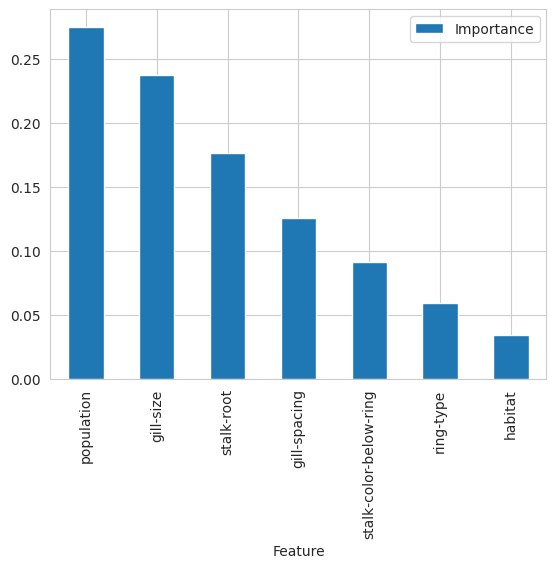

In [91]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False))

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

We will store the best_features to use at a later stage.

In [92]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['population',
 'gill-size',
 'stalk-root',
 'gill-spacing',
 'stalk-color-below-ring',
 'ring-type',
 'habitat']

---

# Cluster Analysis

Load function that plots a table with description for all clusters

In [94]:
def DescriptionAllClusters(df, decimal_points=3):
    """  provides a dataframe describing the distribution of clusters in the dataset """
    DescriptionAllClusters = pd.DataFrame(columns=df.drop(['Clusters'], axis=1).columns)

    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):
    """ Produces statistical information on the distribution of variable categories in each cluster """
    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)

    for col in EDA_Cluster.columns:
        try:
            top_frequencies = EDA_Cluster.dropna(subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
            Description = ''

            for x in range(len(top_frequencies)):
                freq = top_frequencies.iloc[x]
                category = top_frequencies.index[x][0]
                CategoryPercentage = int(round(freq*100, 0))
                statement = f"'{category}': {CategoryPercentage}% , "
                Description = Description + statement

            ClustersDescription.at[0, col] = Description[:-2]
            
        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription

Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

In [95]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count', color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array', tickvals=df['Clusters'].unique()))
    fig.show()

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)', color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array', tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show()

Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.

In [96]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(8124, 8)


,population,gill-size,stalk-root,gill-spacing,stalk-color-below-ring,ring-type,habitat,Clusters
0,scattered,narrow,equal,close,white,pendant,urban,2
1,numerous,broad,club,close,white,pendant,grasses,2
2,numerous,broad,club,close,white,pendant,meadows,2


We want also to analyse edibility levels.

In [97]:
df_edible = pd.read_csv("outputs/datasets/collection/mushrooms.csv").filter(['edible'])
df_edible['edible'] = df_edible['edible'].astype('object')
df_edible.head(3)

,edible
0,0
1,1
2,1


### Cluster profile based on the best features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_edible], axis=1), decimal_points=0)
clusters_profile

### Cluster distribution across edible levels & Relative Percentage of edible in each cluster

In [ ]:
df_cluster_vs_edible=  df_edible.copy()
df_cluster_vs_edible['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_edible, target='class')

## Fit New Cluster Pipeline with most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [ ]:
best_features_pipeline_all_variables

### Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will

1. Conduct a elbow method and silhouette analysis and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"

If we are happy to say yes for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!

### Subset data with the most relevant variables

In [ ]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

### Rewrite Cluster Pipeline

In [ ]:
def PipelineCluster():
    pipeline_base = Pipeline([

        # we update the pipeline, considering only the most important variables from the previous pipeline
        ("TargetEncoder", TargetEncoder()),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # No PCA step needed, since we know which features to consider

        ("model", KMeans(n_clusters=4, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()

### Apply Elbow Method and Silhouette analysis


In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced, df['class'])

print(df_analysis.shape,'\n', type(df_analysis))

Elbow Analysis

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 9

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

## Fit New Cluster Pipeline

Set X as training set for the cluster. It's a copy of df_reduced.

In [ ]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X, df['class'])

## Add cluster predictions to dataset

We add column `Clusters` (with cluster pipeline predictions) to the dataset

In [ ]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

In [ ]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Compare current cluster predictions to previous cluster predictions

Just fitted a new cluster pipeline, and wish to compare if its predictions are "equivalent" to the previous cluster.

These are the predictions from the previous cluster pipeline - trained with all variables

In [ ]:
cluster_predictions_with_all_variables

And these are the predictions from current cluster pipeline (trained with `['gill-size', 'stalk-surface-below-ring', 'gill-spacing', 'population', 'bruises', 'stalk-root']`)

In [ ]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

We use a confusion matrix to evaluate if the predictions of both pipelines are "equivalent"

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

The ordering of the middle two clusters has been reversed, but otherwise these two pipelines are reasonably equivalent.

### Fit a classifier, where the target is cluster predictions and features remaining variables

In [ ]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

Split Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)

Rewrite pipeline to explain clusters

In [ ]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([

        ("TargetEncoder", TargetEncoder()),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # we don't consider feature selection step, since we know which features to consider

        ("model", AdaBoostClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()

### Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [ ]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

### Evaluate classifier performance on Train and Test Sets

In [ ]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

In [ ]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

## Assess Most Important Features


In [ ]:
# since we don't have feature selection step in this pipeline, best_features is Xtrain columns
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Cluster Analysis

Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.

In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

We want also to analyse edibility levels

In [ ]:
df_edible = pd.read_csv("outputs/datasets/collection/mushrooms.csv").filter(['class'])
df_edible['class'] = df_edible['class'].astype('object')
df_edible.head(3)

### Cluster profile on most important features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_edible], axis=1), decimal_points=0)
clusters_profile

### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_edible=  df_edible.copy()
df_cluster_vs_edible['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_edible, target='class')

## Which pipeline to deploy

In [ ]:
pipeline_cluster

## Push files to Repo

We will generate the following files

* Cluster Pipeline
* Train Set
* Feature Importance plot
* Clusters Description
* Cluster Silhouette~

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Cluster pipeline

In [ ]:
pipeline_cluster

In [ ]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

## Train Set

In [ ]:
print(df_reduced.shape)
df_reduced.head(3)

In [ ]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [ ]:
clusters_profile

In [ ]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

In [ ]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)